In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import optimizers, regularizers, models, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle, randint
import numpy as np
import future
from keras.applications import VGG16

import matplotlib.pyplot as plt
import os, shutil
from os import listdir
from os.path import join, isfile, exists
from keras.models import load_model, model_from_json
from pathlib import Path

In [4]:
def make_dir_helper(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
        return True
    return False

In [5]:
def delete_dir_helper(dir_path):
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
        return True
    return False

In [6]:
project_dir_name = 'Esri Project'
original_dataset_dir = join(os.path.expanduser('~'),'Desktop', project_dir_name, 'original data');
base_dir =  join(os.path.expanduser('~'), 'Desktop', project_dir_name, 'data');
base_scripts_dir =  join(os.path.expanduser('~'), 'Desktop', project_dir_name, 'scripts');
model_dir =  join(os.path.expanduser('~'), 'Desktop', project_dir_name, 'models');

MODEL_FILE_NAME = 'map_multi_model_2.h5'
CLASSES_TO_CLASSIFY = ['Airplane', 'Beach', 'Buildings', 'Forest', 'Freeway', 'Parkinglot']
ext = '.jpg'
IMAGE_SIZE = 150
EPOCHS = 17
NO_TRAINING_SAMPLES = 70
BATCH_SIZE = 15
STEPS_PER_EPOCH = 5

train_dir = join(base_dir, 'train')
validation_dir = join(base_dir, 'validation')
test_dir = join(base_dir, 'test')
model_file_path = join(model_dir, MODEL_FILE_NAME)

# Delete the previous data folder and all its contents
delete_dir_helper(base_dir)

make_dir_helper(base_dir)
make_dir_helper(model_dir)

# Make base directories
make_dir_helper(train_dir)
make_dir_helper(validation_dir)
make_dir_helper(test_dir)

for classes in CLASSES_TO_CLASSIFY:
    
    train_class_dir = join(train_dir, classes)
    validation_class_dir = join(validation_dir, classes)
    test_class_dir = join(test_dir, classes)
    
    # Make train sub directories
    make_dir_helper(train_class_dir)
    make_dir_helper(validation_class_dir)
    make_dir_helper(test_class_dir)
    
    indexes = [i for i in range(100)]
    shuffle(indexes)
    train_indexes = indexes[:70]
    test_indexes = indexes[70:100]
    
    fnames = [(classes + '{}' + ext).format(i) for i in train_indexes]
    for fname in fnames:
        src_dir = join(original_dataset_dir, fname)
        dst_dir = join(train_class_dir, fname)
        shutil.copyfile(src_dir, dst_dir)

    # Copy classes into the validation dataset
    fnames = [(classes + '{}' + ext).format(i) for i in test_indexes]
    for fname in fnames:
        src_dir = join(original_dataset_dir, fname)
        dst_dir = join(validation_class_dir, fname)
        shutil.copyfile(src_dir, dst_dir)

    # Copy classes into the test dataset
    fnames = [(classes + '{}' + ext).format(i) for i in test_indexes]
    for fname in fnames:
        src_dir = join(original_dataset_dir, fname)
        dst_dir = join(test_class_dir, fname)
        shutil.copyfile(src_dir, dst_dir)

In [7]:
is_model_from_file = False
model = None
if exists(model_file_path):
    print('found model!')
    model = load_model(model_file_path)
    is_model_from_file = True
else:
    print('No saved model')

No saved model


In [8]:
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       vertical_flip=True,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       horizontal_flip=True)  
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
            train_dir,  
            target_size=(IMAGE_SIZE, IMAGE_SIZE),  
            batch_size=BATCH_SIZE,
            class_mode='categorical')  

    validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical')

Found 420 images belonging to 6 classes.
Found 180 images belonging to 6 classes.


In [9]:
    for idx, (data_batch, labels_batch) in enumerate(train_generator):
        print('data batch:', data_batch.shape)
        print('labels batch:', labels_batch.shape)
        break

data batch: (15, 150, 150, 3)
labels batch: (15, 6)


In [10]:
#     model = models.Sequential()
#     model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(conv_base)
#     model.add(layers.Flatten())
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dense(6, activation='softmax'))

In [11]:
    model = models.Sequential()
    conv_base = VGG16(weights='imagenet' ,include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    conv_base.trainable = False
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='sigmoid'))

In [12]:
model.compile(loss='categorical_crossentropy',
            optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 16,813,638
Trainable params: 2,098,950
Non-trainable params: 14,714,688
_________________________________________________________________


Epoch 1/17
10/10 [==============================] - 85s - loss: 2.3666 - acc: 0.1867 - val_loss: 2.2201 - val_acc: 0.1667
Epoch 2/17
10/10 [==============================] - 54s - loss: 2.2033 - acc: 0.2267 - val_loss: 2.0572 - val_acc: 0.4000
Epoch 3/17
10/10 [==============================] - 54s - loss: 2.0585 - acc: 0.2733 - val_loss: 1.8243 - val_acc: 0.4667
Epoch 4/17
10/10 [==============================] - 54s - loss: 2.0215 - acc: 0.3000 - val_loss: 1.7035 - val_acc: 0.4667
Epoch 5/17
10/10 [==============================] - 54s - loss: 1.7682 - acc: 0.3800 - val_loss: 2.5029 - val_acc: 0.3000
Epoch 6/17
10/10 [==============================] - 54s - loss: 1.6736 - acc: 0.4800 - val_loss: 1.5008 - val_acc: 0.6133
Epoch 7/17
10/10 [==============================] - 54s - loss: 1.3181 - acc: 0.6400 - val_loss: 1.3384 - val_acc: 0.5467
Epoch 8/17
10/10 [==============================] - 54s - loss: 1.3741 - acc: 0.6800 - val_loss: 1.0006 - val_acc: 0.8267
Epoch 9/17
10/10 [======

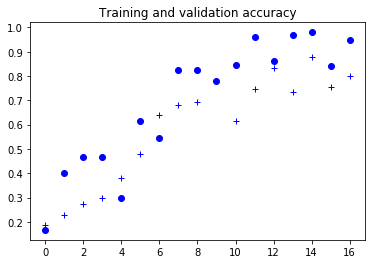

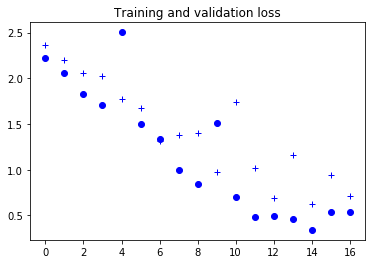

In [14]:
if not is_model_from_file:
    
    callbacks = [
        EarlyStopping(monitor='acc', patience=2, mode='auto'),
        ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath=model_file_path)
    ]
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=10,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks = callbacks,
        validation_steps=10)

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b+')
    plt.plot(epochs, val_acc, 'bo')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, 'b+')
    plt.plot(epochs, val_loss, 'bo')
    plt.title('Training and validation loss')

    plt.show()

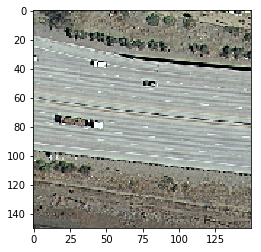

[ 0.  0.  0.  0.  1.  0.]
[4]
Freeway


In [31]:
fnames = []
target_dir = train_dir
dnames = [os.path.join(target_dir, dname) for dname in os.listdir(target_dir)]
for dname in dnames:
    fnames.extend([os.path.join(dname, fname) for fname in os.listdir(dname)])
fnames
shuffle(fnames)
img_path = fnames[randint(0, len(fnames))]

img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
imgplot = plt.imshow(img)
plt.show()

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
prediction = model.predict(x)[0]
print(prediction)

max_indexes = (np.argwhere(prediction == np.amax(prediction))).flatten()
print(max_indexes)

for idx in max_indexes:
    if prediction[idx] > 0.8:
        print(CLASSES_TO_CLASSIFY[idx])
    else:
        print('Unknown')